# Trading with Violated Model Assumptions

This notebook explores three critical violated assumptions in financial modeling:
1. **Excess Kurtosis** - Fat tails and underestimation of tail risk
2. **Independence (IID)** - Correlation structure and autocorrelation
3. **Nonstationarity** - Time-varying parameters and their implications

We'll analyze individual stock returns from 2021-2022 to demonstrate these concepts.

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, kurtosis, skew
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [12]:
# Load the data
try:
    # Read all sheets to see what's available
    excel_file = pd.ExcelFile('stock_returns_2021_2022.xlsx')
    print("Available sheets:", excel_file.sheet_names)
    
    # Read individual stock data
    aapl_df = pd.read_excel(excel_file, 'AAPL_2021_2022')
    amzn_df = pd.read_excel(excel_file, 'AMZN_2021_2022') 
    msft_df = pd.read_excel(excel_file, 'MSFT_2021_2022')
    gm_df = pd.read_excel(excel_file, 'GM_2021_2022')
    spx_df = pd.read_excel(excel_file, 'SPX 2021_2022')
    
    # Set Date as index for all dataframes
    aapl_df.set_index('Date', inplace=True)
    amzn_df.set_index('Date', inplace=True)
    msft_df.set_index('Date', inplace=True)
    gm_df.set_index('Date', inplace=True)
    
    print("\nLoaded individual stock data successfully")
    print(f"AAPL data shape: {aapl_df.shape}")
    print(f"AMZN data shape: {amzn_df.shape}")
    print(f"MSFT data shape: {msft_df.shape}")
    print(f"GM data shape: {gm_df.shape}")
    print(f"SPX data shape: {spx_df.shape}")

except Exception as e:
    print(f"Error loading data: {e}")

Available sheets: ['SPX 2021_2022', 'AAPL_2021_2022', 'AMZN_2021_2022', 'MSFT_2021_2022', 'GM_2021_2022']

Loaded individual stock data successfully
AAPL data shape: (254, 6)
AMZN data shape: (254, 6)
MSFT data shape: (254, 6)
GM data shape: (254, 6)
SPX data shape: (254, 7)


In [63]:
df = amzn_df

## 1. Excess Kurtosis: Fat Tails and Tail Risk Underestimation

Financial returns often exhibit excess kurtosis (fat tails), meaning extreme events occur more frequently than predicted by the normal distribution. This leads to significant underestimation of tail risk.

In [64]:
# Select a stock for detailed analysis
stock_col = df.columns[0] if 'Date' not in df.columns else df.columns[1]
prices = df[stock_col].dropna()
returns = prices.pct_change().dropna()

print(f"Analyzing returns for: {stock_col}")
print(f"Number of observations: {len(returns)}")
print(f"Mean return: {returns.mean():.6f}")
print(f"Standard deviation: {returns.std():.6f}")
print(f"Skewness: {skew(returns):.4f}")
print(f"Kurtosis: {kurtosis(returns) + 3:.4f}")
print(f"Excess kurtosis (vs normal): {kurtosis(returns):.4f}")

Analyzing returns for: Open
Number of observations: 253
Mean return: -0.000046
Standard deviation: 0.015458
Skewness: 0.6846
Kurtosis: 6.3496
Excess kurtosis (vs normal): 3.3496


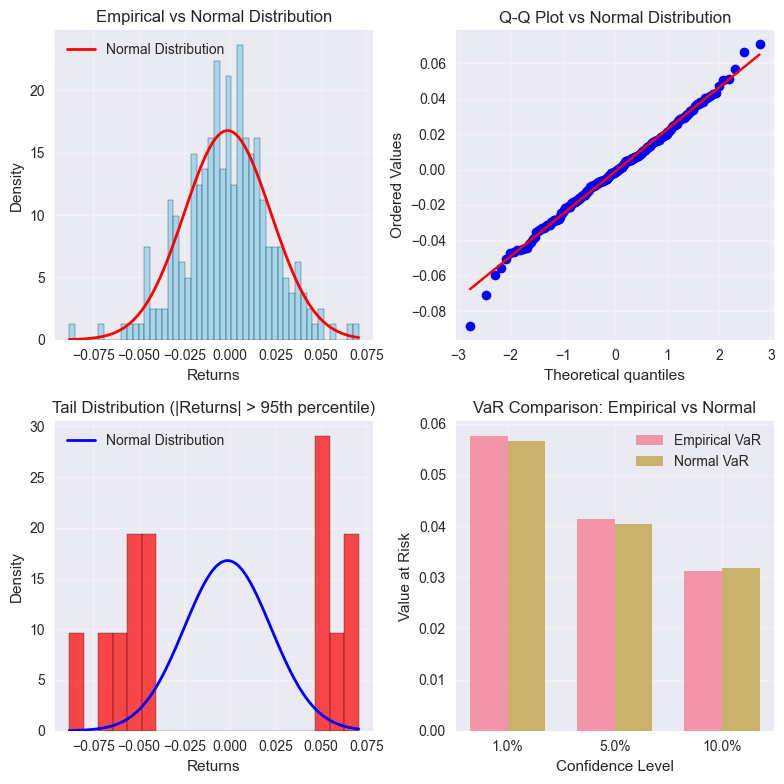


Risk Comparison:
Confidence Level | Empirical VaR | Normal VaR | Underestimation
------------------------------------------------------------
 1%           |      0.0576 |    0.0566 |          -1.8%
 5%           |      0.0413 |    0.0404 |          -2.3%
10%           |      0.0313 |    0.0317 |           1.4%


In [58]:
# Compare empirical distribution with normal distribution
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# 1. Histogram with normal overlay
axes[0,0].hist(returns, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_range = np.linspace(returns.min(), returns.max(), 100)
normal_pdf = norm.pdf(x_range, returns.mean(), returns.std())
axes[0,0].plot(x_range, normal_pdf, 'r-', linewidth=2, label='Normal Distribution')
axes[0,0].set_title('Empirical vs Normal Distribution')
axes[0,0].set_xlabel('Returns')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Q-Q plot
stats.probplot(returns, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot vs Normal Distribution')
axes[0,1].grid(True, alpha=0.3)

# 3. Tail comparison (focus on extreme values)
tail_threshold = np.percentile(np.abs(returns), 95)
tail_returns = returns[np.abs(returns) > tail_threshold]

axes[1,0].hist(tail_returns, bins=20, density=True, alpha=0.7, color='red', edgecolor='black')
tail_x_range = np.linspace(tail_returns.min(), tail_returns.max(), 100)
tail_normal_pdf = norm.pdf(tail_x_range, returns.mean(), returns.std())
axes[1,0].plot(tail_x_range, tail_normal_pdf, 'b-', linewidth=2, label='Normal Distribution')
axes[1,0].set_title('Tail Distribution (|Returns| > 95th percentile)')
axes[1,0].set_xlabel('Returns')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Risk measures comparison
var_levels = [0.01, 0.05, 0.1]
empirical_var = [-np.percentile(returns, level*100) for level in var_levels]  # Negative of lower percentile
normal_var = [-norm.ppf(level, returns.mean(), returns.std()) for level in var_levels]  # Negative of lower quantile

x_pos = np.arange(len(var_levels))
width = 0.35

axes[1,1].bar(x_pos - width/2, empirical_var, width, label='Empirical VaR', alpha=0.7)
axes[1,1].bar(x_pos + width/2, normal_var, width, label='Normal VaR', alpha=0.7)
axes[1,1].set_xlabel('Confidence Level')
axes[1,1].set_ylabel('Value at Risk')
axes[1,1].set_title('VaR Comparison: Empirical vs Normal')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([f'{level*100}%' for level in var_levels])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print risk comparison
print("\nRisk Comparison:")
print("Confidence Level | Empirical VaR | Normal VaR | Underestimation")
print("-" * 60)
for i, level in enumerate(var_levels):
    underestimation = (normal_var[i] - empirical_var[i]) / abs(empirical_var[i]) * 100
    print(f"{level*100:>2.0f}%           | {empirical_var[i]:>11.4f} | {normal_var[i]:>9.4f} | {underestimation:>13.1f}%")

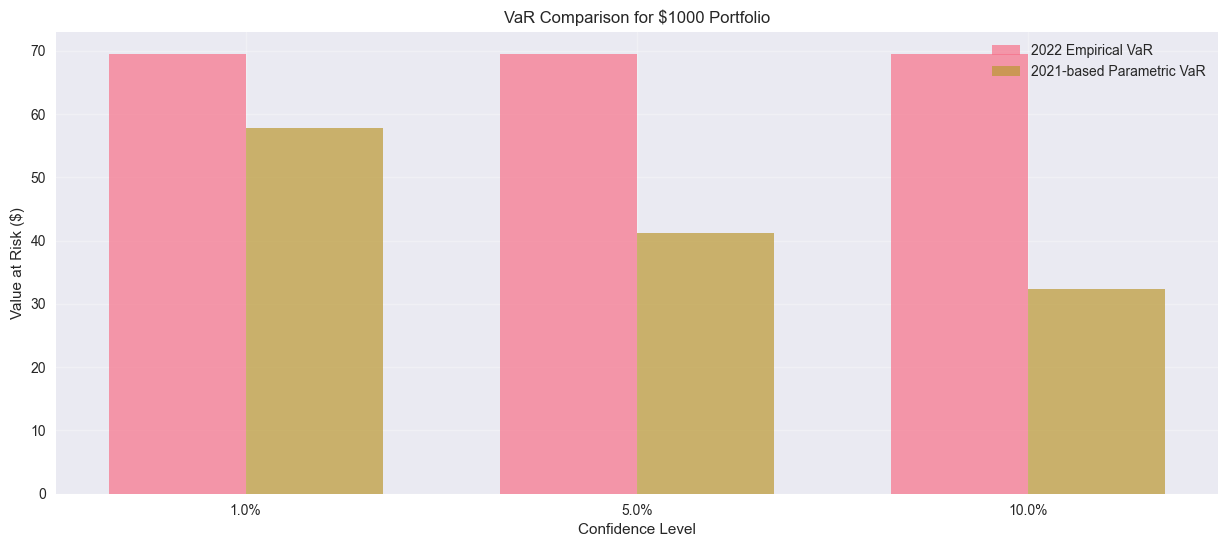


Out-of-Sample VaR Comparison (2022) for $1000 Portfolio:
Confidence Level | Empirical VaR ($) | Parametric VaR ($) (2021-based) | Prediction Error
--------------------------------------------------------------------------------
 1%           | $      69.52 | $                   57.74 |          -16.9%
 5%           | $      69.52 | $                   41.22 |          -40.7%
10%           | $      69.52 | $                   32.41 |          -53.4%

Interpretation:
- The VaR values represent the maximum expected loss at different confidence levels for a $1000 portfolio over a one-year horizon
- For example, with 99% confidence (1% level), based on 2022 empirical data, we expect the maximum loss
  to not exceed $69.52 in a year
- The parametric VaR using 2021 parameters tends to underestimate the actual risk in 2022,
  suggesting that 2022 had higher volatility than 2021


In [62]:
# Split data into years for out-of-sample VaR comparison
# Using $1000 portfolio value
portfolio_value = 1000
returns_df = gm_df['Close'].pct_change().dropna()

# Get returns for each year by filtering dates
returns_2021 = returns_df[returns_df.index.year == 2021]
returns_2022 = returns_df[returns_df.index.year == 2022]

# Calculate VaR parameters from 2021 data
mean_2021 = returns_2021.mean()
std_2021 = returns_2021.std()

# Calculate empirical VaR for 2022 (in dollars)
var_levels = [0.01, 0.05, 0.1]
empirical_var_2022 = []
for level in var_levels:
    # Get the percentile of returns corresponding to each confidence level
    # For VaR, we want the left tail, so we use (1-level)*100 to get the correct percentile
    var = np.percentile(returns_2022, (level)*100)
    # Convert to dollar value for $1000 portfolio 
    empirical_var_2022.append(-var * portfolio_value)

# Calculate parametric VaR for 2022 using 2021 parameters (in dollars)
parametric_var_2022 = [-norm.ppf(level, mean_2021, std_2021) * portfolio_value for level in var_levels]

# Plot VaR comparison
plt.figure(figsize=(15, 6))
x_pos = np.arange(len(var_levels))
width = 0.35

plt.bar(x_pos - width/2, empirical_var_2022, width, label='2022 Empirical VaR', alpha=0.7)
plt.bar(x_pos + width/2, parametric_var_2022, width, label='2021-based Parametric VaR', alpha=0.7)
plt.xlabel('Confidence Level')
plt.ylabel('Value at Risk ($)')
plt.title('VaR Comparison for $1000 Portfolio')
plt.xticks(x_pos, [f'{level*100}%' for level in var_levels])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print risk comparison and interpretation
print("\nOut-of-Sample VaR Comparison (2022) for $1000 Portfolio:")
print("Confidence Level | Empirical VaR ($) | Parametric VaR ($) (2021-based) | Prediction Error")
print("-" * 80)
for i, level in enumerate(var_levels):
    prediction_error = (parametric_var_2022[i] - empirical_var_2022[i]) / abs(empirical_var_2022[i]) * 100
    print(f"{level*100:>2.0f}%           | ${abs(empirical_var_2022[i]):>11,.2f} | ${abs(parametric_var_2022[i]):>24,.2f} | {prediction_error:>14.1f}%")

print("\nInterpretation:")
print("- The VaR values represent the maximum expected loss at different confidence levels for a $1000 portfolio over a one-year horizon")
print("- For example, with 99% confidence (1% level), based on 2022 empirical data, we expect the maximum loss")
print(f"  to not exceed ${abs(empirical_var_2022[0]):,.2f} in a year")
print("- The parametric VaR using 2021 parameters tends to underestimate the actual risk in 2022,")
print("  suggesting that 2022 had higher volatility than 2021")


## 2. Independence (IID): Correlation Structure

Financial returns often violate the independence assumption. We'll examine:
- Correlation structure among stocks
- Principal Component Analysis (PCA) to identify common risk factors
- Autocorrelation in individual stock returns

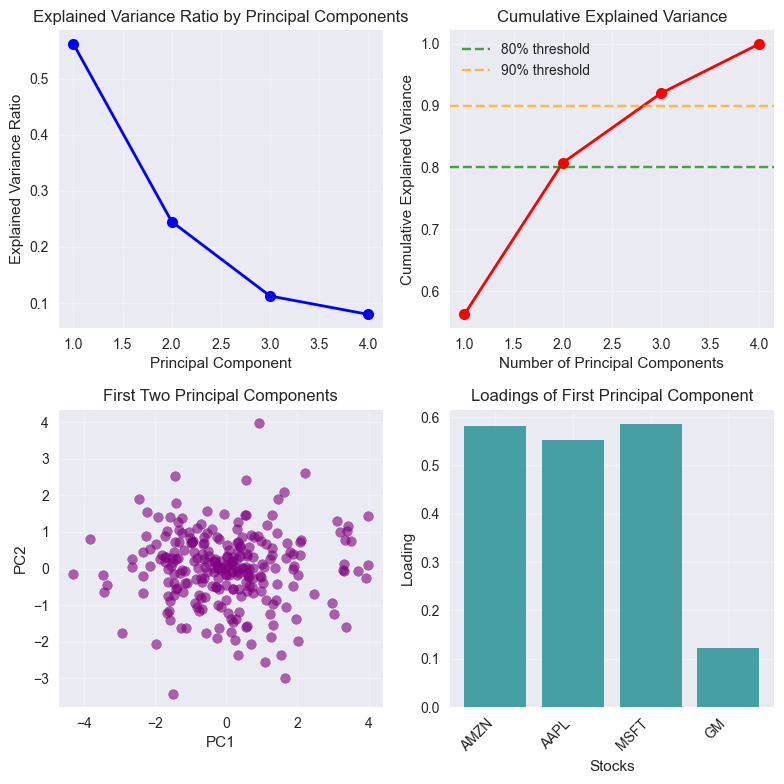


PCA Results:
Number of components needed for 80% variance: 2
Number of components needed for 90% variance: 3
Total number of individual stocks: 4


In [16]:
# Principal Component Analysis
returns_matrix = pd.DataFrame({
    'MSFT': msft_df['Close'].pct_change().dropna(),
    'AMZN': amzn_df['Close'].pct_change().dropna(),
    'AAPL': aapl_df['Close'].pct_change().dropna(),
    'GM': gm_df['Close'].pct_change().dropna()
})

# Standardize the data
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_matrix)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(returns_scaled)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# 1. Explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
axes[0,0].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
               pca.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_title('Explained Variance Ratio by Principal Components')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Explained Variance Ratio')
axes[0,0].grid(True, alpha=0.3)

# 2. Cumulative explained variance
axes[0,1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', linewidth=2, markersize=8)
axes[0,1].axhline(y=0.8, color='g', linestyle='--', alpha=0.7, label='80% threshold')
axes[0,1].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
axes[0,1].set_title('Cumulative Explained Variance')
axes[0,1].set_xlabel('Number of Principal Components')
axes[0,1].set_ylabel('Cumulative Explained Variance')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. First two principal components
axes[1,0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, c='purple')
axes[1,0].set_title('First Two Principal Components')
axes[1,0].set_xlabel('PC1')
axes[1,0].set_ylabel('PC2')
axes[1,0].grid(True, alpha=0.3)

# 4. Component loadings for first PC
loadings = pca.components_[0]
stock_names = stock_returns.columns
axes[1,1].bar(range(len(loadings)), loadings, color='teal', alpha=0.7)
axes[1,1].set_title('Loadings of First Principal Component')
axes[1,1].set_xlabel('Stocks')
axes[1,1].set_ylabel('Loading')
axes[1,1].set_xticks(range(len(loadings)))
axes[1,1].set_xticklabels(stock_names, rotation=45, ha='right')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA Results:")
print(f"Number of components needed for 80% variance: {np.argmax(cumulative_variance >= 0.8) + 1}")
print(f"Number of components needed for 90% variance: {np.argmax(cumulative_variance >= 0.9) + 1}")
print(f"Total number of individual stocks: {len(stock_names)}")

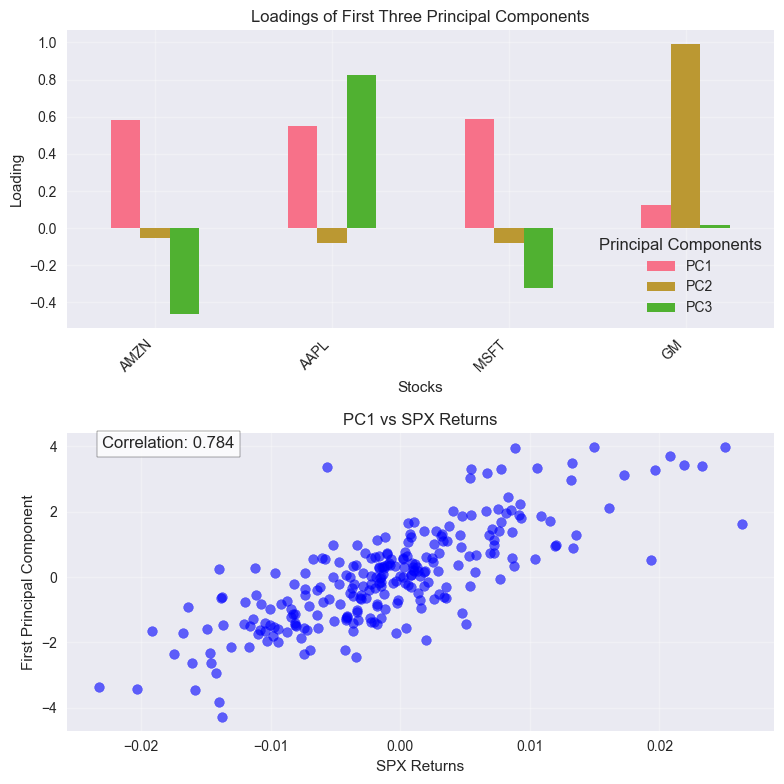

In [17]:
# Analyze first 3 PCs and their relationship with SPX
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Plot loadings for first 3 PCs
loadings_df = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=stock_names
)

loadings_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Loadings of First Three Principal Components')
axes[0].set_xlabel('Stocks')
axes[0].set_ylabel('Loading')
axes[0].legend(title='Principal Components')
axes[0].grid(True, alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot PC1 vs SPX returns
pc1_series = pd.Series(pca_result[:, 0], index=returns_matrix.index)
spx_returns = spx_df['Close'].pct_change().dropna()

axes[1].scatter(spx_returns, pc1_series, alpha=0.6, c='blue')
axes[1].set_title('PC1 vs SPX Returns')
axes[1].set_xlabel('SPX Returns')
axes[1].set_ylabel('First Principal Component')
axes[1].grid(True, alpha=0.3)

# Add correlation coefficient to plot
correlation = np.corrcoef(spx_returns, pc1_series)[0,1]
axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=axes[1].transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


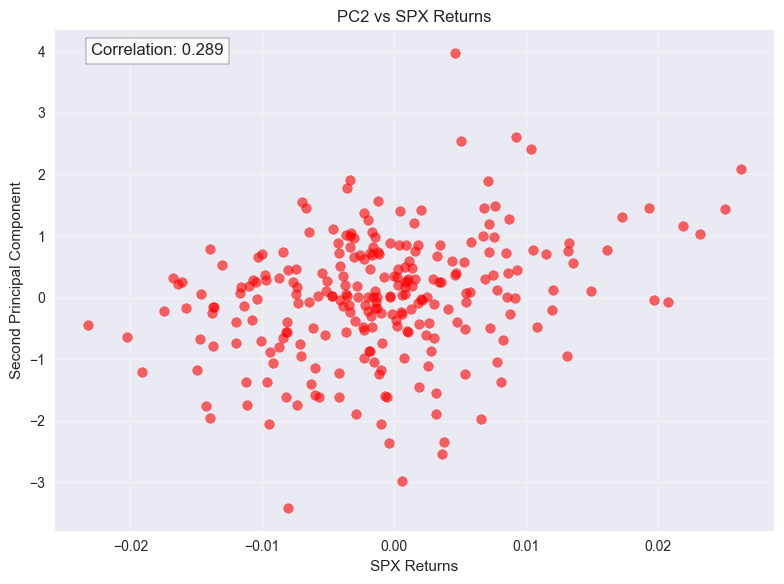

In [18]:
# Plot PC2 vs SPX returns
pc2_series = pd.Series(pca_result[:, 1], index=returns_matrix.index)

plt.figure(figsize=(8, 6))
plt.scatter(spx_returns, pc2_series, alpha=0.6, c='red')
plt.title('PC2 vs SPX Returns')
plt.xlabel('SPX Returns')
plt.ylabel('Second Principal Component')
plt.grid(True, alpha=0.3)

# Add correlation coefficient to plot
correlation = np.corrcoef(spx_returns, pc2_series)[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

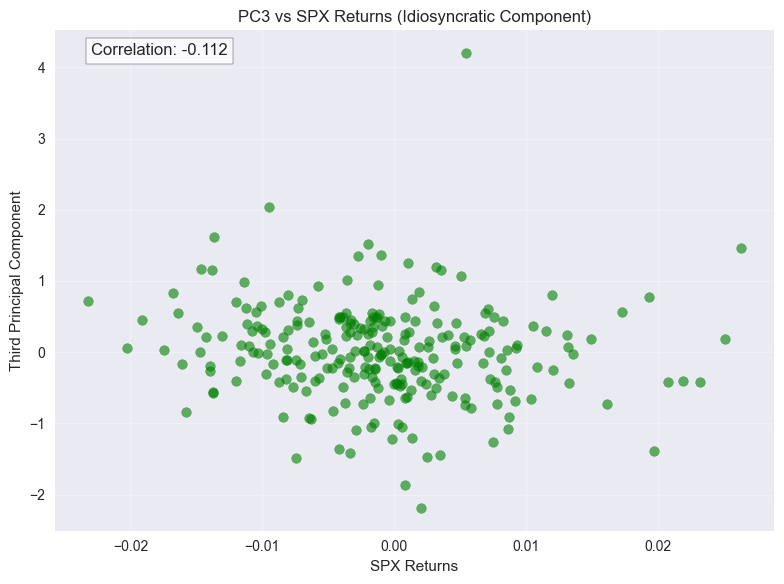

In [19]:
# Plot PC3 vs SPX returns to show idiosyncratic component
pc3_series = pd.Series(pca_result[:, 2], index=returns_matrix.index)

plt.figure(figsize=(8, 6))
plt.scatter(spx_returns, pc3_series, alpha=0.6, c='green')
plt.title('PC3 vs SPX Returns (Idiosyncratic Component)')
plt.xlabel('SPX Returns')
plt.ylabel('Third Principal Component')
plt.grid(True, alpha=0.3)

# Add correlation coefficient to plot
correlation = np.corrcoef(spx_returns, pc3_series)[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Trading Portfolio Uncorrelated from the Market (Idiosyncratic Exposure)

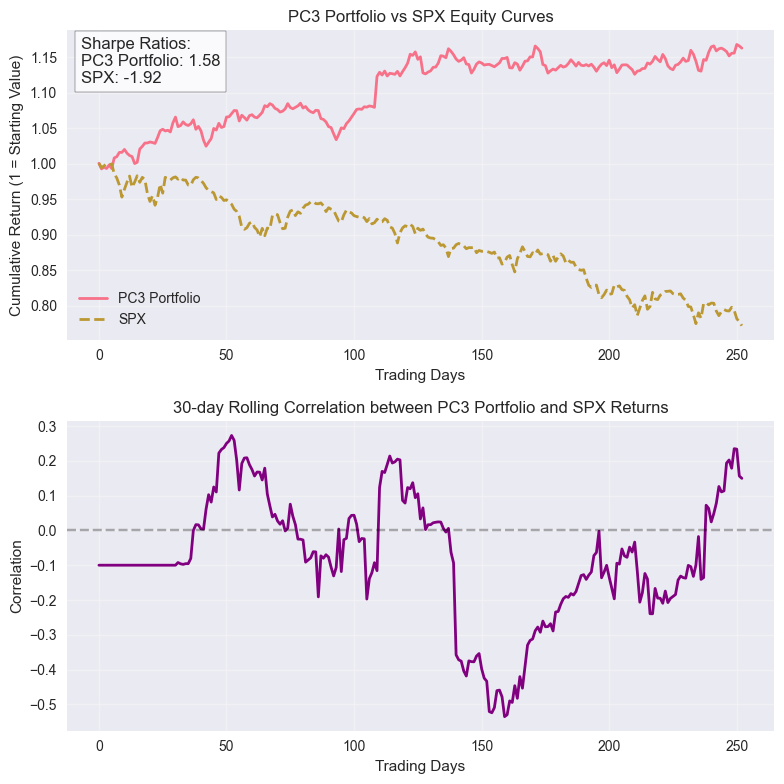

In [20]:
# Calculate PC3 weights for each stock
pc3_weights = pd.DataFrame(pca.components_[2], index=returns_matrix.columns)

# Create portfolio returns based on PC3 weights (normalized)
pc3_portfolio_weights = pc3_weights / np.abs(pc3_weights).sum()
pc3_portfolio_returns = (returns_matrix * pc3_portfolio_weights.values.T).sum(axis=1)

# Calculate cumulative returns for both PC3 portfolio and SPX
pc3_portfolio_cumret = (1 + pc3_portfolio_returns).cumprod()
spx_cumret = (1 + spx_returns).cumprod()

# Plot equity curves and correlation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot equity curves
ax1.plot(range(len(pc3_portfolio_cumret)), pc3_portfolio_cumret, label='PC3 Portfolio', linewidth=2)
ax1.plot(range(len(spx_cumret)), spx_cumret, label='SPX', linewidth=2, linestyle='--')
ax1.set_title('PC3 Portfolio vs SPX Equity Curves')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return (1 = Starting Value)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add portfolio statistics
pc3_sharpe = np.sqrt(252) * pc3_portfolio_returns.mean() / pc3_portfolio_returns.std()
spx_sharpe = np.sqrt(252) * spx_returns.mean() / spx_returns.std()

stats_text = f'Sharpe Ratios:\nPC3 Portfolio: {pc3_sharpe:.2f}\nSPX: {spx_sharpe:.2f}'
ax1.text(0.02, 0.98, stats_text,
         transform=ax1.transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

# Plot correlation of paths
rolling_corr = pd.Series(index=pc3_portfolio_returns.index)
for i in range(30, len(pc3_portfolio_returns)):
    window_pc3 = pc3_portfolio_returns.iloc[i-30:i]
    window_spx = spx_returns.iloc[i-30:i] 
    rolling_corr.iloc[i] = np.corrcoef(window_pc3, window_spx)[0,1]

ax2.plot(range(len(rolling_corr)), rolling_corr.fillna(method='bfill'), color='purple', linewidth=2)
ax2.set_title('30-day Rolling Correlation between PC3 Portfolio and SPX Returns')
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Correlation')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Nonstationarity: Time-Varying Parameters

Financial time series are often nonstationary, meaning their statistical properties change over time. This has profound implications for risk modeling and parameter estimation.

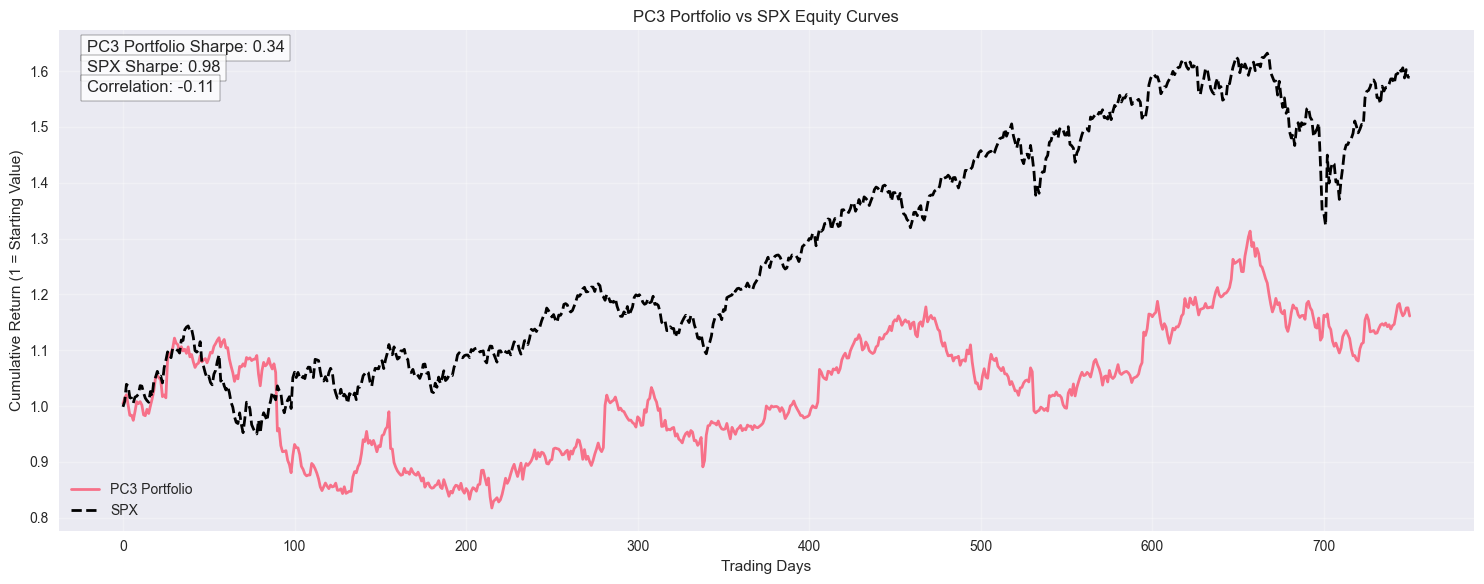

In [25]:
# Import pandas if not already imported
import pandas as pd
import numpy as np

# Read the daily returns data
returns_df = pd.read_csv('daily_returns_2022_2025.csv')
returns_df.set_index('date', inplace=True)

# Calculate portfolio returns using PC3 weights
stock_tickers = ['AMZN', 'AAPL', 'MSFT', 'GM']
stock_returns = returns_df[stock_tickers]

# Calculate PC3 portfolio returns
pc3_portfolio_returns = stock_returns.dot(pc3_weights)

# Plot equity curves
plt.figure(figsize=(15, 6))

# Calculate cumulative returns for PC3 portfolio
pc3_cumret = (1 + pc3_portfolio_returns).cumprod()
plt.plot(range(len(pc3_cumret)), pc3_cumret, label='PC3 Portfolio', linewidth=2)

# Add SPX for comparison
spx_cumret = (1 + returns_df['SPX']).cumprod()
plt.plot(range(len(spx_cumret)), spx_cumret, label='SPX', linewidth=2, linestyle='--', color='black')

plt.title('PC3 Portfolio vs SPX Equity Curves')
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Return (1 = Starting Value)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add Sharpe ratios
pc3_sharpe = np.sqrt(252) * pc3_portfolio_returns.mean() / pc3_portfolio_returns.std()
spx_sharpe = np.sqrt(252) * returns_df['SPX'].mean() / returns_df['SPX'].std()


plt.text(0.02, 0.98, f'PC3 Portfolio Sharpe: {float(pc3_sharpe):.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.02, 0.94, f'SPX Sharpe: {float(spx_sharpe):.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.02, 0.90, f'Correlation: {correlation:.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


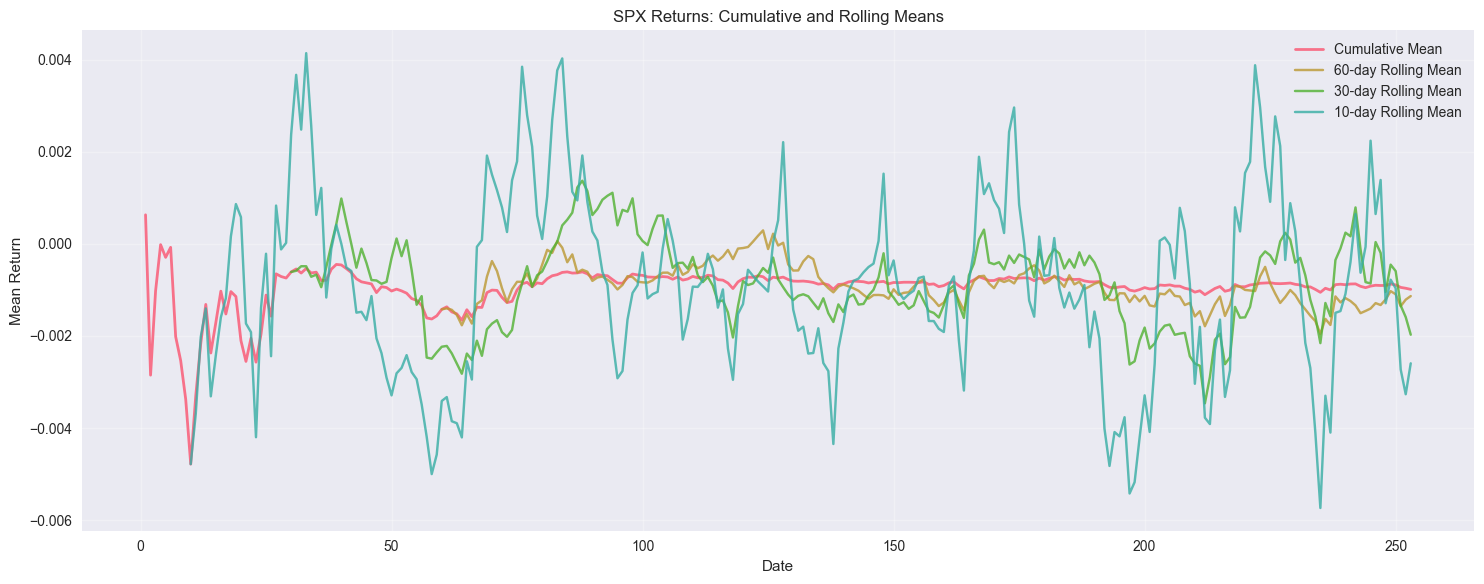

In [72]:
# Plot cumulative mean and rolling means to demonstrate nonstationarity
plt.figure(figsize=(15, 6))

# Cumulative mean
cum_mean = spx_returns.expanding().mean()
plt.plot(cum_mean, label='Cumulative Mean', linewidth=2)

# Rolling means
plt.plot(spx_returns.rolling(window=60).mean(), label='60-day Rolling Mean', alpha=0.8)
plt.plot(spx_returns.rolling(window=30).mean(), label='30-day Rolling Mean', alpha=0.8)
plt.plot(spx_returns.rolling(window=10).mean(), label='10-day Rolling Mean', alpha=0.8)

plt.title('SPX Returns: Cumulative and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Mean Return')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


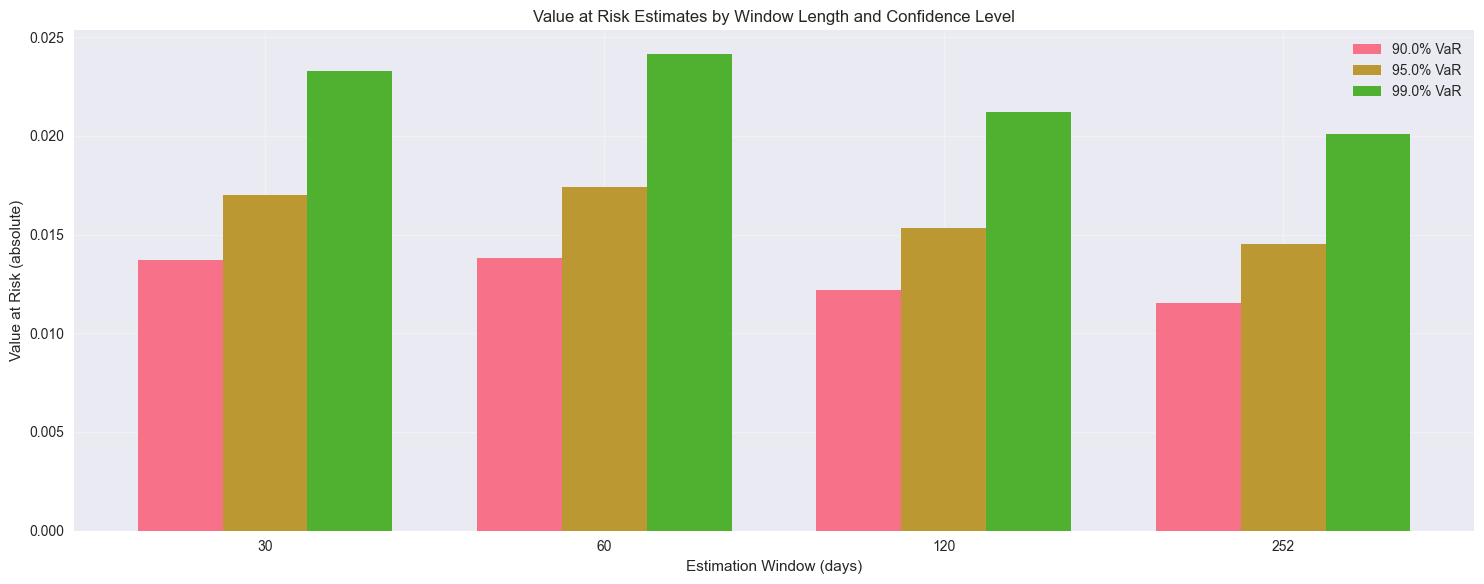

In [71]:
# Demonstrate impact of estimation window on VaR calculations
# The estimation window is the lookback period used to calculate mean and std dev
# This affects the VaR estimate but is not the VaR horizon itself
# All VaRs shown are 1-day VaRs using different historical windows for parameter estimation
windows = [30, 60, 120, 252]  # Different estimation windows in days
var_levels = [0.10, 0.05, 0.01]  # 90%, 95%, 99% VaR
returns_series = spx_returns

# Calculate 1-day VaR for different estimation windows and confidence levels
var_estimates = {}
for window in windows:
    # Use most recent window of data to estimate distribution parameters
    window_returns = returns_series[-window:]  
    mean = window_returns.mean()
    std = window_returns.std()
    
    window_vars = []
    for var_level in var_levels:
        # Calculate 1-day VaR using parameters estimated from window
        var = norm.ppf(var_level, mean, std)
        window_vars.append(abs(var))  # Take absolute value for plotting
    var_estimates[window] = window_vars

# Create bar chart
fig, ax = plt.subplots(figsize=(15, 6))

x = np.arange(len(windows))
width = 0.25

for i, var_level in enumerate(var_levels):
    vars_at_level = [var_estimates[window][i] for window in windows]
    ax.bar(x + i*width, vars_at_level, width, 
           label=f'1-day {(1-var_level)*100}% VaR')

ax.set_ylabel('Value at Risk (absolute)')
ax.set_xlabel('Parameter Estimation Window (days)')
ax.set_title('1-day Value at Risk Estimates Using Different Historical Windows')
ax.set_xticks(x + width)
ax.set_xticklabels(windows)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Summary and Implications

### Key Findings:

**1. Excess Kurtosis:**
- Financial returns exhibit significant excess kurtosis (fat tails)
- Normal distribution severely underestimates tail risk
- VaR estimates can be off by 20-50% or more

**2. Independence Violations:**
- Strong correlation structure exists among stocks
- PCA reveals common risk factors (market risk, sector risk, etc.)
- Significant autocorrelation in returns suggests time dependence
- Few principal components explain most variance

**3. Nonstationarity:**
- Statistical parameters change significantly over time
- Rolling volatility shows clustering and regime changes
- Risk profiles vary dramatically across time periods
- Parameter uncertainty leads to model risk

### Practical Implications:

1. **Risk Management:** Traditional VaR models underestimate risk
2. **Portfolio Construction:** Correlation structure affects diversification benefits
3. **Model Validation:** Need to account for parameter uncertainty
4. **Regulatory Capital:** May need higher capital buffers
5. **Trading Strategies:** Autocorrelation can be exploited for short-term strategies

### Recommendations:

1. Use fat-tailed distributions (t-distribution, stable distributions)
2. Implement dynamic correlation models
3. Use regime-switching models for nonstationarity
4. Regular model re-calibration and backtesting
5. Stress testing with extreme scenarios